In [ ]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
# mount our data from shared drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


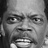

In [ ]:
# loading a sample image
sample_image = Image.open("/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [ ]:
# check shape
np.array(sample_image).shape

(48, 48)

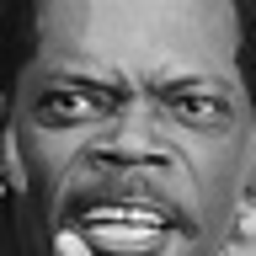

In [ ]:
# resize image
sample_image = sample_image.resize([256,256])
sample_image

In [ ]:
# ensuring shape after resize
np.array(sample_image).shape

(256, 256)

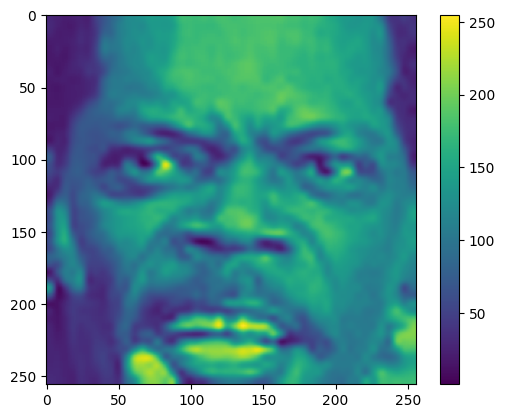

In [ ]:
# put a fake color channel
plt.imshow(np.array(sample_image))
plt.colorbar()
plt.show()

## Extract only face from images

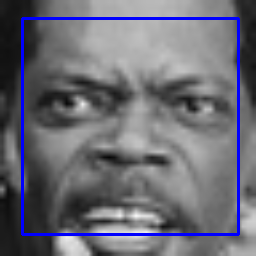

In [ ]:
# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)

In [ ]:
# check shape
cropped_img.shape

(256, 256, 3)

In [ ]:
# crop image
cropped_img = cropped_img.sum(axis=2)

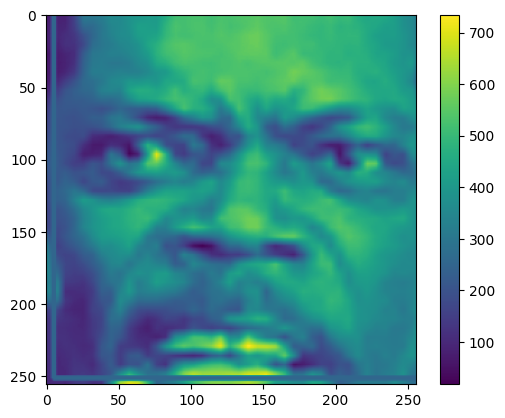

In [ ]:
# plot cropped image
plt.imshow(cropped_img)
plt.colorbar()

## Load Data and Extract only Face

In [ ]:
def load_normalize(image_path, normalized=True):
    """Load and normalize image from path"""
    image = Image.open(image_path).resize([128,128])
    image = np.array(image).astype(np.float32)
    if len(image.shape) == 3:
        image = image.sum(axis=2)
    if normalized:
        return image / 255.0
    else:
        return image

emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))

In [ ]:
# code to load all the data, assuming dataset is at /content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [ ]:
print(f"There are {len(x_data)} in total.")

There are 27546 in total.


In [ ]:
# ensuring our dataset
for i,emo in enumerate(emo_types):
  print(emo,":", y_data.count(i))

angry : 3977
disgust : 551
fear : 3867
happy : 7230
neutral : 4580
sad : 4696
surprise : 2645


(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


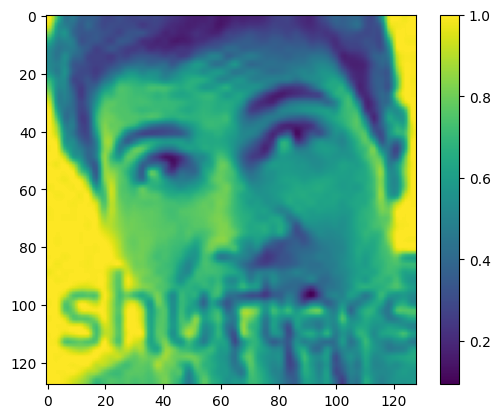

In [ ]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

# Final Model

In [ ]:
# load the model that our team trained
VGG16_model_final = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_final")

In [ ]:
# check the model summary
VGG16_model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                        

In [ ]:
# make a heatmap
last_conv_layer_name = "conv2d_9"

def get_img_array(img_path, size):
    """getting image array from path"""
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

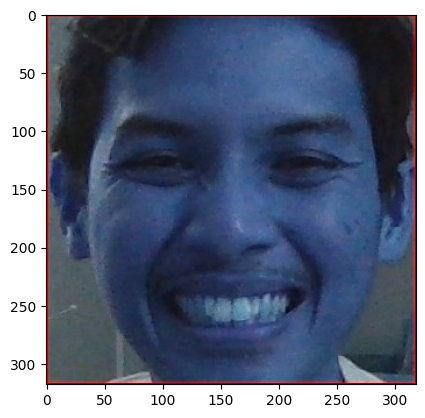

In [ ]:
# use face cascade to detect faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# detect face from this image
img = cv2.imread('/content/gdrive/MyDrive/Expression Dataset/validation_report/w_happy_1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# crop the face
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    cv2.imwrite('/content/gdrive/MyDrive/Expression Dataset/validation_report/w_happy_1_cl.jpg', roi_color)
    img = cv2.imread('/content/gdrive/MyDrive/Expression Dataset/validation_report/w_happy_1_cl.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('/content/gdrive/MyDrive/Expression Dataset/validation_report/w_happy_1_cl.jpg', gray)

# plot the result
plt.imshow(img)

1/1 [==============================] - 0s 73ms/step
[[-0.9790815 -1.8065882  5.0663424 -3.6822276 -1.1820879  3.7518883
  -0.63951  ]]
fear


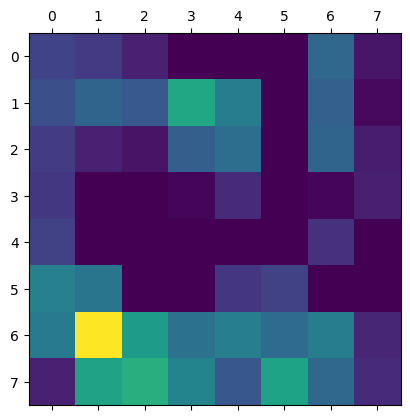

In [ ]:
# load image to be predicted
img_path = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/fear/4453.jpg'

# Prepare image to have size (-1, 128, 128, 1)
img_array = load_normalize(img_path)
img_array = img_array.reshape(-1, 128, 128, 1)

model = VGG16_model_final

# Remove last layer's activation function
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)
# print prediction based on the model emo list
print(emo_types[np.argmax(preds)])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-87-2119af453bb2>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("CMRmap")


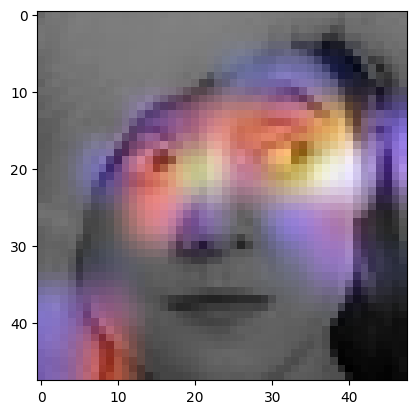

In [ ]:
import matplotlib.cm as cm
def display_gradcam(img_path, heatmap, alpha=1):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # colorize the using function other than get_cmap
    jet = cm.get_cmap("CMRmap")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    # save the superimposed image as an array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    # make into an array
    superimposed_img = np.array(superimposed_img)

    # display Grad CAM in 256x256
    return superimposed_img


# Display Grad CAM
plt.imshow(display_gradcam(img_path, heatmap))

# Final Saliency

1/1 [==============================] - 0s 43ms/step


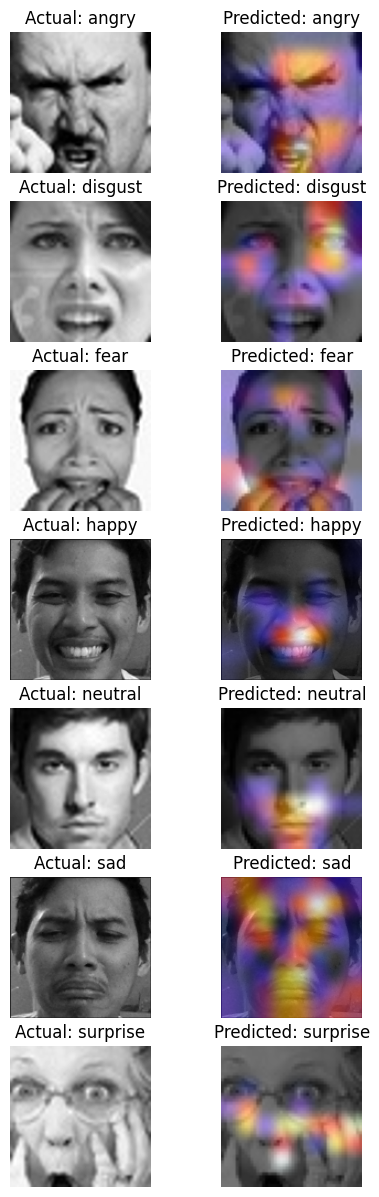

In [ ]:
# create a subplot to plot all the images and their respective heatmaps
fig, ax = plt.subplots(7, 2, figsize=(5, 15))

angry = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/angry/3137.jpg'
disgust = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/disgust/533.jpg'
fear = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/fear/4453.jpg'
happy = '/content/gdrive/MyDrive/Expression Dataset/validation_report/w_happy_1_cl.jpg'
neutral = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/neutral/1093.jpg'
sad = '/content/gdrive/MyDrive/Expression Dataset/validation_report/w_sad_2_cl.jpg'
surprise = '/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/surprise/6877.jpg'

import warnings
warnings.filterwarnings("ignore")

# Loop through each emotion and create a heatmap for each with the actual label and predicted value above it
for i, emotion in enumerate([angry, disgust, fear, happy, neutral, sad, surprise]):
    # make a subplot with 2 columns and 4 rows
    img_array = load_normalize(emotion)
    img_array = img_array.reshape(-1, 128, 128, 1)
    ax[i, 0].imshow(img_array[0,:,:,0], cmap='gray')
    ax[i, 0].set_title(f"Actual: {emo_types[i]}")
    ax[i, 0].axis('off')
    # make a subplot with 2 columns and 4 rows
    # Prepare image to have size (None, 128, 128, 1)
    model = VGG16_model_final

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    # print prediction based on the model emo list
    predx = (emo_types[np.argmax(preds)])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    ax[i, 1].imshow(img_array[0,:,:,0], cmap='gray')
    ax[i, 1].set_title(f"Predicted: {predx}")
    ax[i, 1].imshow(display_gradcam(emotion, heatmap))
    ax[i, 1].axis('off')

plt.show()